In [3]:
import cv2 as cv
import matplotlib.pyplot as plt 


In [4]:
net = cv.dnn.readNetFromTensorflow("graph_opt.pb") #weights 


In [5]:
inWidth = 368 
inHeight = 368 
thr = 0.2

In [6]:
BODY_PARTS = { "Nose": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
               "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
               "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "REye": 14,
               "LEye": 15, "REar": 16, "LEar": 17, "Background": 18 }

POSE_PAIRS = [ ["Neck", "RShoulder"], ["Neck", "LShoulder"], ["RShoulder", "RElbow"],
               ["RElbow", "RWrist"], ["LShoulder", "LElbow"], ["LElbow", "LWrist"],
               ["Neck", "RHip"], ["RHip", "RKnee"], ["RKnee", "RAnkle"], ["Neck", "LHip"],
               ["LHip", "LKnee"], ["LKnee", "LAnkle"], ["Neck", "Nose"], ["Nose", "REye"],
               ["REye", "REar"], ["Nose", "LEye"], ["LEye", "LEar"] ]



In [7]:
img = cv.imread("pose.jpg") #BGR

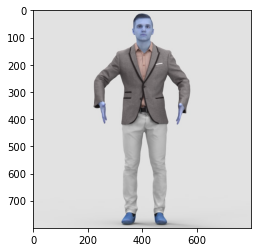

In [8]:
plt.imshow(img)

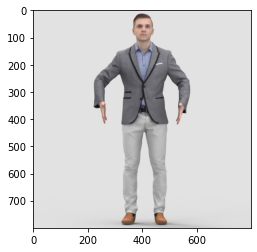

In [9]:
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))

In [10]:
def pose_estimation(frame):
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    points = [None] * len(BODY_PARTS)  # Initialize points list with None values

    net.setInput(cv.dnn.blobFromImage(frame, 1.0, (inWidth, inHeight), (127.5, 127.5, 127.5), swapRB=True, crop=False))
    out = net.forward()
    out = out[:, :19, :, :]

    assert(len(BODY_PARTS) == out.shape[1])

    # Iterate over body parts and find the points
    for partId in range(len(BODY_PARTS)):
        heatMap = out[0, partId, :, :]
        _, conf, _, point = cv.minMaxLoc(heatMap)
        x = (frameWidth - point[0]) / out.shape[3]
        y = (frameHeight - point[1]) / out.shape[2]

        # Only update the point if the confidence is above 'thr'
        if conf > thr:
            points[partId] = (int(x), int(y))

    for pair in POSE_PAIRS:
        partFrom = pair[0]
        partTo = pair[1]
        assert(partFrom in BODY_PARTS)
        assert(partTo in BODY_PARTS)

        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]

        if points[idFrom] and points[idTo]:
            cv.line(frame, points[idFrom], points[idTo], (0, 225, 0), 3)
            cv.ellipse(frame, points[idFrom], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)
            cv.ellipse(frame, points[idTo], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)

    t, _ = net.getPerfProfile()
    freq = cv.getTickFrequency() / 1000
    cv.putText(frame, '%.2fms' % (t / freq), (10, 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))
    return frame


In [11]:
estimated_image = pose_estimation(img)


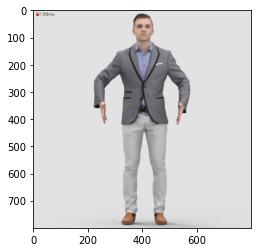

In [12]:
plt.imshow(cv.cvtColor(estimated_image, cv.COLOR_BGR2RGB))

In [14]:
cap = cv.VideoCapture(1)

cap.set(cv.CAP_PROP_FPS, 10)
cap.set(3, 800)
cap.set(4, 800)

if not cap.isOpened():
    cap = cv.VideoCapture(0)
if not cap.isOpened():
    raise IOError("Cannot Open Webcam")

while cv.waitKey(1) != 27:  # Exit the loop when the 'Esc' key (27) is pressed
    hasFrame, frame = cap.read()
    if not hasFrame:
        cv.waitKey()
        break

    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    net.setInput(cv.dnn.blobFromImage(frame, 1.0, (inWidth, inHeight), (127.5, 127.5, 127.5), swapRB=True, crop=False))
    out = net.forward()
    out = out[:, :19, :, :]

    assert(len(BODY_PARTS) == out.shape[1])

    points = []

    for i in range(len(BODY_PARTS)):

        heatMap = out[0, i, :, :]

        _, conf, _, point = cv.minMaxLoc(heatMap)
        x = (frameWidth * point[0]) / out.shape[3]
        y = (frameHeight * point[1]) / out.shape[2]

        # Add a point if its confidence is higher than the threshold
        points.append((int(x), int(y)) if conf > thr else None)

    for pair in POSE_PAIRS:
        partFrom = pair[0]
        partTo = pair[1]
        assert(partFrom in BODY_PARTS)
        assert(partTo in BODY_PARTS)

        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]

        if points[idFrom] and points[idTo]:
            cv.line(frame, points[idFrom], points[idTo], (0, 255, 0), 3)
            cv.ellipse(frame, points[idFrom], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)
            cv.ellipse(frame, points[idTo], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)

    t, _ = net.getPerfProfile()
    freq = cv.getTickFrequency() / 1000
    cv.putText(frame, '%.2fms' % (t / freq), (10, 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))

    cv.imshow('OpenPose FUnny', frame)

# Release the video capture and close the OpenCV windows
cap.release()
cv.destroyAllWindows()


[ WARN:0@246.915] global cap_v4l.cpp:982 open VIDEOIO(V4L2:/dev/video1): can't open camera by index
[ERROR:0@246.915] global obsensor_uvc_stream_channel.cpp:156 getStreamChannelGroup Camera index out of range
